# Regresión lineal regularizada

En esta práctica vamos a comprobar los efectos que tienen el sesgo y la varianza en la regresión lineal. En primer lugar cargamos los datos; en esta ocasión el archivo _ex5data1.mat_ separa claramente los conjuntos de prueba y validación, así que vamos a visualizar la muestra:

In [1]:
import numpy as np
import scipy.optimize as opt
from scipy.io import loadmat
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import cm
import matplotlib.pyplot as plt

In [2]:
def load_data(filename):
    data = loadmat(filename)
    return data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']

In [5]:
def test_one():
    X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')
    print("Shapes of X{} and y{}".format(X.shape, y.shape))
    print("Shapes of Xval{} and yval{}".format(Xval.shape, yval.shape))
    print("Shapes of Xtest{} and ytest{}".format(Xtest.shape, ytest.shape))
    plt.figure(figsize=(8, 6))
    plt.xlabel('Cambios en el nivel del agua')
    plt.ylabel('Agua desbordada')
    plt.plot(X, y, 'rx')
    plt.show()

Shapes of X(12, 1) and y(12, 1)
Shapes of Xval(21, 1) and yval(21, 1)
Shapes of Xtest(21, 1) and ytest(21, 1)


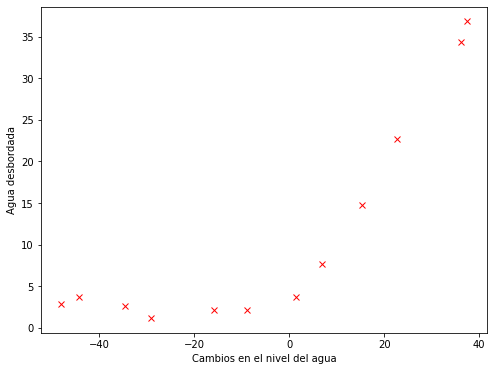

In [6]:
test_one()

A continuación, vamos a implementar las funciones para el coste y el gradiente de la regresión lineal. Ambas se implementan de forma vectorizando aplicando la fórmula dada. Posteriormente, se calcula el término de regularización y se suma al resultado obtenido:

In [7]:
def cost(theta, X, y, Lambda):
    m = np.shape(X)[0]
    theta = theta.reshape(-1, y.shape[1])
    unreg_term = (1 / (2 * m)) * np.sum(np.square(np.dot(X, theta) - y))
    reg_term = (Lambda / (2 * m)) * np.sum(np.square(theta[1:len(theta)]))
    return unreg_term + reg_term

def grad(theta, X, y, Lambda):
    m = np.shape(X)[0]
    theta = theta.reshape(-1, y.shape[1])
    grad = np.zeros(theta.shape)
    grad = (1 / m) * np.dot(X.T, np.dot(X, theta) - y) + (Lambda / m ) * theta
    unreg_grad = (1 / m) * np.dot(X.T, np.dot(X, theta) - y)
    grad[0] = unreg_grad[0]
    return grad.flatten()

def linear_reg_cost(Theta, X, Y, Lambda):
    return cost(Theta, X, Y, Lambda), grad(Theta, X, Y, Lambda)

Si aplicamos las funciones de coste y gradiente regularizado a nuestros datos, con valores iniciales para theta de (1, 1), obtenemos los resultados esperados para el coste y el gradiente:

In [8]:
def test_two():
    Lambda = 1.0
    theta = np.array([[1], [1]])
    X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')
    X_ones = np.hstack([np.ones([np.shape(X)[0], 1]), X])
    cost, grad = linear_reg_cost(theta, X_ones, y, Lambda)
    print('Coste y Gradiente para theta = [1, 1]:', cost, grad)

In [9]:
test_two()

Coste y Gradiente para theta = [1, 1]: 303.9931922202643 [-15.30301567 598.25074417]


Utilizando la función scipy.optimize.minimize podemos aplicar regresión lineal a los ejemplos; para utilizarla, definimos una función interna cost_func() que se ajusta a los parámetros que espera recibir y devolver la función de scipy:

In [10]:
def linear_reg_train(X, y, Lambda):
    theta = np.zeros([X.shape[1], 1])
    def cost_func(Theta):
        return linear_reg_cost(Theta, X, y, Lambda)
    result = opt.minimize(fun=cost_func, x0=theta, method='CG', jac=True, options={'maxiter':200})
    return result.x

Aplicando esta función con un valor de la tasa de aprendizaje de 0.0, dado que el tamaño de la muestra es reducido, obtenemos la siguiente recta de regresión lineal. Como veremos en el siguiente apartado, esta representación no se ajusta al modelo por su simpleza; se dice que los valores que predice esta recta de regresión lineal están _sesgados_ :

In [15]:
def test_three():
    Lambda = 0.0
    X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')
    X_ones = np.hstack([np.ones([np.shape(X)[0], 1]), X])
    theta = linear_reg_train(X_ones, y, Lambda)
    print('Theta: ', theta)
    plt.figure(figsize=(8, 6))
    plt.xlabel('Cambios en el nivel del agua')
    plt.ylabel('Agua desbordada')
    plt.plot(X, y, 'rx')
    plt.plot(X, np.dot(np.insert(X, 0, 1, axis=1), theta))
    plt.show()

Theta:  [13.08790351  0.36777923]


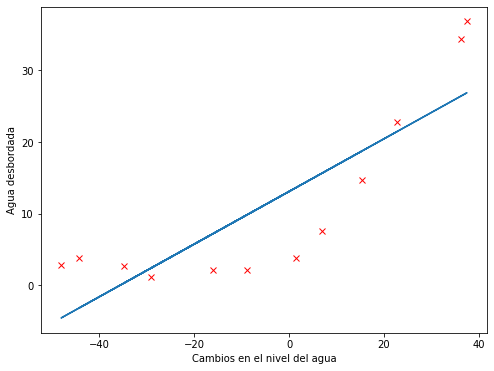

In [16]:
test_three()

# Curvas de aprendizaje

Las curvas de aprendizaje pueden ayudarnos a detectar situaciones de sesgo (y varianza). Tras aplicar regresión lineal a un subconjunto de nuestra muestra, necesitamos calcular el error que se produce en dicho subconjunto de ejemplos de entrenamiento, y compararlo con el error que se desprende del conjunto de validación: 

In [17]:
def learning_curve(X, y, Xval, yval, Lambda):
    m = X.shape[0]
    error_train = np.zeros([m, 1])
    error_val = np.zeros([m, 1])
    for i in range(1, m + 1):
        theta = linear_reg_train(X[:i], y[:i], Lambda)
        error_train[i - 1] = linear_reg_cost(theta, X[:i], y[:i], 0)[0]
        error_val[i - 1] = linear_reg_cost(theta, Xval, yval, 0)[0]
    return error_train, error_val

In [18]:
def test_four():
    Lambda = 0.0
    X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')
    m = X.shape[0]
    X_ones = np.hstack([np.ones([m, 1]), X])
    Xval_ones = np.hstack([np.ones([Xval.shape[0], 1]), Xval])
    error_train, error_val = learning_curve(X_ones, y, Xval_ones, yval, Lambda)

    plt.figure(figsize=(8, 6))
    plt.xlabel('No. Ejemplos de Entrenamiento')
    plt.ylabel('Error')
    plt.plot(range(1, m + 1), error_train, 'b', label='Entrenamiento')
    plt.plot(range(1, m + 1), error_val, 'y', label='Validacion')
    plt.legend()
    plt.show()

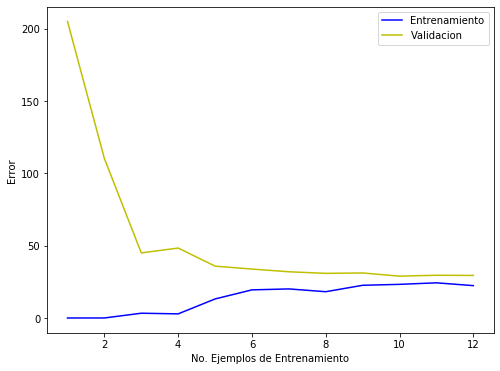

In [19]:
test_four()

# Regresión polinomial

En este apartado vamos a ver el ejemplo contrario: un sobreajuste a los datos (medido por la varianza). Como ya habíamos visto, podemos "aumentar" el número de atributos de nuestra muestra mediante polinomios. 

Para empezar, implementamos una función capaz de tomar nuestros datos de entrada y transformarlos. Si recibe una matriz de _m x 1_ dimensioens, devolverá una matriz de _m x p_ dimensiones, siendo _p_ el grado del polinomio deseado:

In [20]:
def poly_feature(X, p):
    X_poly = X
    for i in range(1, p):
        X_poly = np.column_stack((X_poly, np.power(X, i + 1)))
    return X_poly

Llevar a cabo esta operación tiene ciertas consecuencias, ya que podemos desnormalizar los datos de entrada. La siguiente función normaliza todos los atributos a partir de la media y la varianza, que devuelve junto al parámetro normalizado:

In [21]:
def normalize_feature(X):
    mu = np.mean(X, axis=0)
    X_norm = X - mu
    sigma = np.std(X_norm, axis=0)
    X_norm = X_norm / sigma
    return X_norm, mu, sigma

In [25]:
def plot_fit(min_x, max_x, mu, sigma, theta, p):
    x = np.array(np.arange(min_x, max_x, 0.05))
    X_poly = poly_feature(x, p)
    X_poly = X_poly - mu
    X_poly = X_poly / sigma
    X_poly = np.insert(X_poly, 0, 1, axis=1)
    plt.plot(x, np.dot(X_poly, theta))

Debemos polinomizar y normalizar todos los datos de entrada; para los conjuntos de test y validación, sin embargo, la normalización se lleva a cabo con los valores obtenidos del conjunto de entrenamiento. Generamos los nuevos datos de entrada con _p = 8_ y varios valores para Lambda (0, 1 y 100) para comparar los resultados.

Para generar las curvas de aprendizaje reutilizaremos la función vista anteriormente. Visualizaremos las gráficas que generan los valores theta óptimos obtenidos de cada entrenamiento, así como las correspondientes curvas de aprendizaje:

In [31]:
def test_five():
    p = 8
    X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')
    m = X.shape[0]

    X_poly = poly_feature(X, p)                   # Polinomizar
    X_poly, mu, sigma = normalize_feature(X_poly) # Normalizar
    X_poly = np.insert(X_poly, 0, 1, axis=1)      # Añadir 1s

    X_poly_test = poly_feature(Xtest, p)
    X_poly_test = X_poly_test - mu
    X_poly_test = X_poly_test / sigma
    X_poly_test = np.insert(X_poly_test, 0, 1, axis=1)

    X_poly_val = poly_feature(Xval, p)
    X_poly_val = X_poly_val - mu
    X_poly_val = X_poly_val / sigma
    X_poly_val = np.insert(X_poly_val, 0, 1, axis=1)

    # Entrenamiento regresión lineal con Lambda = 0
    theta = linear_reg_train(X_poly, y, 0)
    plt.figure(figsize=(8, 6))
    plt.xlabel('Cambios en el nivel del agua')
    plt.ylabel('Agua desbordada')
    plt.plot(X, y, 'rx')
    plot_fit(min(X), max(X), mu, sigma, theta, p)
    plt.show()    
    error_train, error_val = learning_curve(X_poly, y, X_poly_val, yval, 0)
    plt.figure(figsize=(8, 6))
    plt.xlabel('No. Ejemplos de Entrenamiento')
    plt.ylabel('Error')
    plt.plot(range(1, m + 1), error_train, 'b', label='Entrenamiento')
    plt.plot(range(1, m + 1), error_val, 'y', label='Validacion')
    plt.legend()
    plt.show()
    
    # Entrenamiento regresión lineal con Lambda = 1
    theta = linear_reg_train(X_poly, y, 1)
    plt.figure(figsize=(8, 6))
    plt.xlabel('Cambios en el nivel del agua')
    plt.ylabel('Agua desbordada')
    plt.plot(X, y, 'rx')
    plot_fit(min(X), max(X), mu, sigma, theta, p)
    plt.show()    
    error_train, error_val = learning_curve(X_poly, y, X_poly_val, yval, 1)
    plt.figure(figsize=(8, 6))
    plt.xlabel('No. Ejemplos de Entrenamiento')
    plt.ylabel('Error')
    plt.plot(range(1, m + 1), error_train, 'b', label='Entrenamiento')
    plt.plot(range(1, m + 1), error_val, 'y', label='Validacion')
    plt.legend()
    plt.show()
    
    # Entrenamiento regresión lineal con Lambda = 100
    theta = linear_reg_train(X_poly, y, 100)
    plt.figure(figsize=(8, 6))
    plt.xlabel('Cambios en el nivel del agua')
    plt.ylabel('Agua desbordada')
    plt.plot(X, y, 'rx')
    plot_fit(min(X), max(X), mu, sigma, theta, p)
    plt.show()    
    error_train, error_val = learning_curve(X_poly, y, X_poly_val, yval, 100)
    plt.figure(figsize=(8, 6))
    plt.xlabel('No. Ejemplos de Entrenamiento')
    plt.ylabel('Error')
    plt.plot(range(1, m + 1), error_train, 'b', label='Entrenamiento')
    plt.plot(range(1, m + 1), error_val, 'y', label='Validacion')
    plt.legend()
    plt.show()

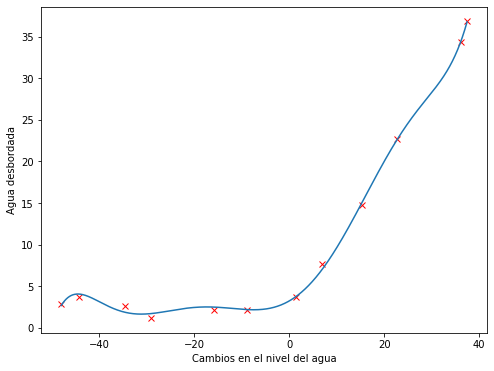

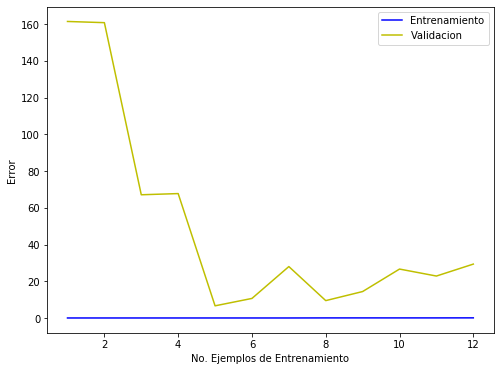

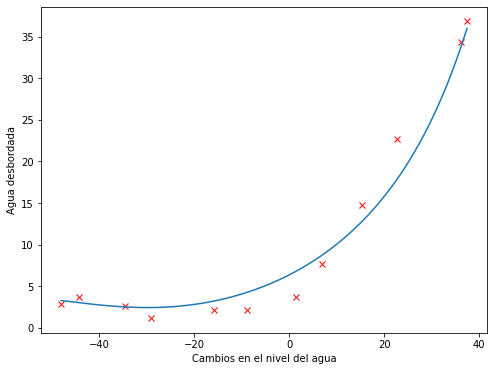

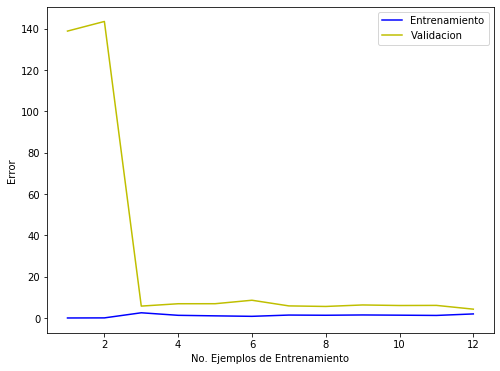

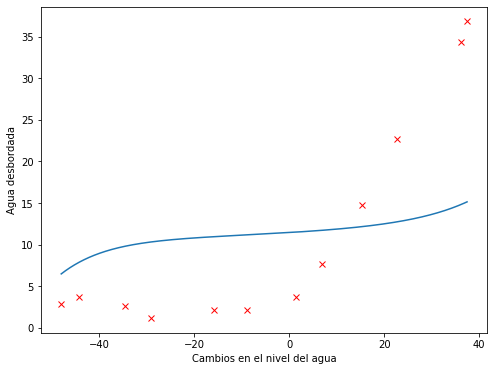

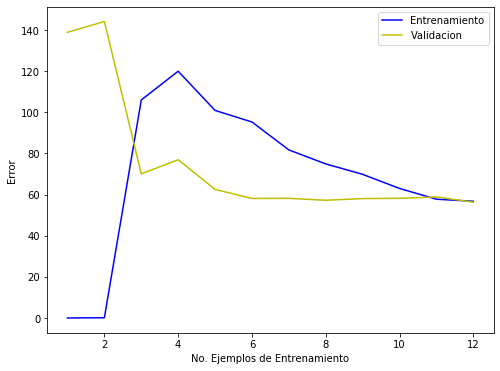

In [32]:
test_five()

# Selección del parámetro λ

En función del parámetro Lambda podemos ajustar más o menos el error en los ejemplos de entrenamiento. Para decidir qué valor de Lambda se ajusta más utilizaremos la función validation_curve(), que lleva a cabo el proceso descrito en el apartado anterior de forma automática para varios valores de Lambda, devolviendo tres vectores con los valores de Lambda utilizados y los errores obtenidos de cada uno de ellos tanto para el conjunto de entrenamiento como el de validación:

In [34]:
def validation_curve(X, y, Xval, yval):
    lambdas = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    error_train = np.zeros((len(lambdas), 1))
    error_val = np.zeros((len(lambdas), 1))
    for i in range(len(lambdas)):
        Lambda = lambdas[i]
        theta = linear_reg_train(X, y, Lambda)
        error_train[i] = linear_reg_cost(theta, X, y, 0)[0]
        error_val[i] = linear_reg_cost(theta, Xval, yval, 0)[0]         
    return lambdas, error_train, error_val

Con los datos obtenidos podemos visualizar la gráfica esperada y comprobar que, efectivamente, el valor más ajustado de Lambda es 3. Para comprobarlo, obtenemos las thetas óptimas aplicando nuevamente la regresión lineal, y calculamos el coste sobre un conjunto que no hayamos utilizado previamente: el conjunto de test. Debemos tener cuidado al calcular este coste sobre elconjunto de test, ya que aquí el parámetro Lambda que pasamos a la función debe ser 0:

In [35]:
def test_six():
    p = 8
    X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')
    m = X.shape[0]

    X_poly = poly_feature(X, p)                   # Polinomizar
    X_poly, mu, sigma = normalize_feature(X_poly) # Normalizar
    X_poly = np.insert(X_poly, 0, 1, axis=1)      # Añadir 1s

    X_poly_test = poly_feature(Xtest, p)
    X_poly_test = X_poly_test - mu
    X_poly_test = X_poly_test / sigma
    X_poly_test = np.insert(X_poly_test, 0, 1, axis=1)

    X_poly_val = poly_feature(Xval, p)
    X_poly_val = X_poly_val - mu
    X_poly_val = X_poly_val / sigma
    X_poly_val = np.insert(X_poly_val, 0, 1, axis=1)

    lambdas, error_train, error_val = validation_curve(X_poly, y, X_poly_val, yval)

    plt.figure(figsize=(8, 6))
    plt.xlabel('$\lambda$')
    plt.ylabel('Error')
    plt.plot(lambdas, error_train, 'b', label='Entrenamiento')
    plt.plot(lambdas, error_val, 'y', label='Validacion')
    plt.legend()
    plt.show()

    theta = linear_reg_train(X_poly, y, 3)
    error_test = linear_reg_cost(theta, X_poly_test, ytest, 0)[0]
    print("Error en el conjunto de test para Lambda = 3: {0:.4f}".format(error_test))

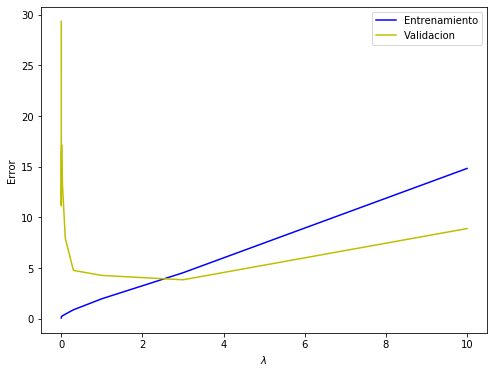

Error en el conjunto de test para Lambda = 3: 3.5720


In [36]:
test_six()

El error obtenido es el esperado.